### Package, Data, and Base Error Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
import pickle

In [2]:
def rmse(predictions, actual):
    mse = mean_squared_error(predictions, actual)
    rmse = sqrt(mse)
    residuals = [predictions-actual]
    return(rmse, residuals)

In [3]:
df_model = pd.read_excel('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\PGA Finish Projections_modeling data.xlsx')

In [4]:
# Base Features
features = ['sg_putt','sg_arg','sg_app','sg_ott','sg_t2g']

# Lagged Strokes-Gained Feature
lag_1_fields = ['sg_putt1','sg_arg1','sg_app1','sg_ott1','sg_t2g1']
lag_2_fields = ['sg_putt2','sg_arg2','sg_app2','sg_ott2','sg_t2g2']
lag_3_fields = ['sg_putt3','sg_arg3','sg_app3','sg_ott3','sg_t2g3']

sg_fields = lag_1_fields+lag_2_fields+lag_3_fields

# Player, Course, and Tournament with Lagged Strokes-Gained
pct_sg_fields = ['player_id']+['tournament_id']+['course_id']+sg_fields

In [5]:
lag_1_fields = ['sg_putt1','sg_arg1','sg_app1','sg_ott1','sg_t2g1']

In [6]:
df_lag_1_features, df_lag_1_target = df_model[lag_1_fields], df_model['strokes_rel_par']

In [7]:
train_lag_1_features, test_lag_1_features, train_lag_1_target, test_lag_1_target = train_test_split(df_lag_1_features, df_lag_1_target, test_size = 0.1)

In [8]:
def simple_rf_fit(train_features, test_features, train_target, test_target):
    
    rf_base = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf_base.fit(train_features, train_target)
    predictions_base = rf_base.predict(test_features)
    errors_base, _ = rmse(predictions_base, test_target)
    base_rmse = round(np.mean(errors_base), 2)
    
    return(base_rmse)

In [9]:
base_rmse = simple_rf_fit(train_features = train_lag_1_features, test_features = test_lag_1_features, 
                          train_target = train_lag_1_target, test_target = test_lag_1_target)

In [10]:
indices = ['player', 'tournament_name', 'course']
    
with open('base_features.pkl', 'wb') as outfile:
    pickle.dump(features, outfile)
    
with open('sg_lag_features.pkl', 'wb') as outfile:
    pickle.dump(sg_fields, outfile)

## 4) Feature Engineering & Model Tuning

In the data we're using, we have used <em>place_adj</em> which assigned a finishing place of 80 to a player who missed the cut.  In most tournaments, half of the players who begin playing on Thursday are cut from the tournament at the end of Friday's round.  This leads to an imbalanced regression target variable, and limits the ability of the model to make accurate predictions.

In the plot below, the histogram shows the distribution of finishes in the dataset:

In [11]:
dfa = df_model.loc[df_model['place_adj']==80]
dfb = df_model.loc[df_model['place_adj']<80]
print(dfa.shape[0], dfb.shape[0])

9427 16549


In [12]:
finishes = df_model['place_adj'].values

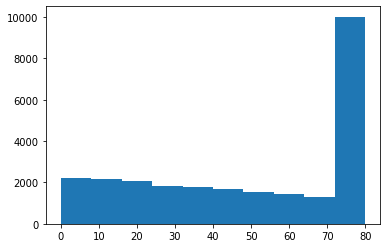

In [13]:
fig = pl.hist(finishes, range = (0,80))

To improve predictive power, I will split our model into two phases:

<ol>
    <li>Classification algorithm which distinguishes players who will make the cut from those who won't</li>
    <li>Regression algorithm which aims to predict how a player will finish if they make the cut</li>
</ol>

For the former I will tune a Support Vector Machine (SVM) which identifies players who are likely to make the cut.  For the players who make the cut, an XG Boost regressor will then be used to predict a player's score relative to par.  Error reduction will be evaluated relative to the previously-established <em>base_error</em>, which represents the prediction of a simple 100-tree RandomForest estimator using nothing but last-week's strokes-gained data for each player.  For streamlined model-checking and -tuning, I will use the following functions to conduct a random hyperparameter grid search.

<ol>
    <li><em>xgb_param_tune</em></li>
    <li><em>svm_param_tune</em></li>
</ol>

In [14]:
def xgb_param_tune(train_features, train_target, test_features, test_target, base_rmse, 
                   param_grid, n_iter, cv, verbose, random_state):
    
    xg = XGBRegressor()
    xg_random = RandomizedSearchCV(estimator = xg, param_distributions = param_grid, 
                                   n_jobs = -1, n_iter = n_iter, cv = cv, verbose = verbose, random_state = random_state)
    xg_random.fit(train_features, train_target)
    best_params = xg_random.best_params_
    
    xg_tuned = XGBRegressor(learning_rate = best_params['learning_rate'], n_estimators = best_params['n_estimators'],
                            gamma = best_params['gamma'], colsample_bytree = best_params['colsample_bytree'], 
                            subsample = best_params['subsample'], max_depth = best_params['max_depth'], 
                            n_jobs = -1, random_state = random_state)
    xg_tuned.fit(train_features, train_target)
    predictions = xg_tuned.predict(test_features)
    
    residuals, _ = rmse(predictions, test_target)
    error = np.mean(residuals)
    error_pct_diff = round(100*(error-base_rmse)/base_rmse, 2)
    
    print_string = '%s: %s' % ('Tuned XG Boost Model with Player, Course, Tournament, and Lagged Strokes-Gained', error_pct_diff)
    print(print_string+'%'+'\n')
    
    return(best_params, error)

In [15]:
def svm_param_tune(train_features, test_features, train_target, test_target, random_grid, n_iter, cv, scoring):
    svm = SVC()
    
    svm_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = n_iter, cv = cv, 
                                    verbose = 3, random_state = 42, n_jobs = -1, scoring = scoring)
    svm_random.fit(train_features, train_target)
    best_params = svm_random.best_params_
    
    svm = SVC(C = best_params['C'], gamma = best_params['gamma'], tol = best_params['tol'])
    svm.fit(train_features, train_target)
    
    class_predictions = svm.predict(test_features)
    cm = confusion_matrix(test_target, class_predictions)
    
    accuracy = (cm[0,0]+cm[1,1])/np.sum(cm)
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    recall = cm[1,1]/(cm[1,0]+cm[1,1])
    
    return(best_params, (accuracy, precision, recall))

##### One-Hot Encoding

By converting the player, tournament, and course values to one-hot vector encodings, we are allowing the decision trees to effectively "turn on" a model for a particular player-event pairing.  In the following section, we will evaluate whether the one-hot encoding approach explains player finishes better than simply leaving player, tournament, and course as columnar values.  If the error decrease is greater, we can conclude that one-hot encoding is a better categorical variable data representation.

In [16]:
df_id = df_model[indices]
df_id.head()

,player,tournament_name,course
0,Aaron Baddeley,AT&T Byron Nelson,TPC Craig Ranch
1,Aaron Baddeley,Valspar Championship,Innisbrook
2,Aaron Baddeley,AT&T Pebble Beach Pro-Am,Pebble Beach
3,Aaron Baddeley,Farmers Insurance Open,Torrey Pines
4,Aaron Baddeley,The American Express,La Quinta CC


In [17]:
df_feat = df_model[sg_fields]
df_feat.head()

,sg_putt1,sg_arg1,sg_app1,sg_ott1,sg_t2g1,sg_putt2,sg_arg2,sg_app2,sg_ott2,sg_t2g2,sg_putt3,sg_arg3,sg_app3,sg_ott3,sg_t2g3
0,1.84,-0.73,-0.39,-1.21,-2.33,0.73,-0.41,-2.67,0.60,-2.47,-0.59,0.38,0.42,-2.04,-1.25
1,0.73,-0.41,-2.67,0.60,-2.47,-0.59,0.38,0.42,-2.04,-1.25,-3.14,-0.72,0.07,-0.22,-0.86
2,-0.59,0.38,0.42,-2.04,-1.25,-3.14,-0.72,0.07,-0.22,-0.86,1.59,-0.94,0.19,-0.35,-1.09
3,-3.14,-0.72,0.07,-0.22,-0.86,1.59,-0.94,0.19,-0.35,-1.09,-0.20,1.07,-1.81,-0.84,-1.58
4,1.59,-0.94,0.19,-0.35,-1.09,-0.20,1.07,-1.81,-0.84,-1.58,-0.11,0.26,0.04,0.08,0.38


In [18]:
df_oh_player = pd.get_dummies(df_id['player'], prefix = 'player')
df_oh_tournament = pd.get_dummies(df_id['tournament_name'], prefix = 'tournament')
df_oh_course = pd.get_dummies(df_id['course'], prefix = 'course')

In [19]:
dfm1 = pd.merge(df_oh_player, df_oh_tournament, left_index = True, right_index = True)
dfm2 = pd.merge(dfm1, df_oh_course, left_index = True, right_index = True)
df_model_oh = pd.merge(dfm2, df_feat, left_index = True, right_index = True)

In [20]:
train_oh_features, test_oh_features, train_oh_target, test_oh_target = train_test_split(df_model_oh, df_model['strokes_rel_par'], test_size = 0.1)

In [21]:
print('The train dataset has %s rows and %s target measurements' % (len(train_oh_features.iloc[:,0]), len(train_oh_target)))
print('The test dataset has %s rows and %s target measurements' % (len(test_oh_features.iloc[:,0]), len(test_oh_target)))

The train dataset has 23605 rows and 23605 target measurements
The test dataset has 2623 rows and 2623 target measurements


In [22]:
oh_rmse = simple_rf_fit(train_features = train_oh_features, test_features = test_oh_features, 
                        train_target = train_oh_target, test_target = test_oh_target)

In [23]:
error_pct_diff = round(100*(oh_rmse-base_rmse)/base_rmse, 2)

print_string = '%s: %s' % ('One-Hot Encoding Percent Error Reduction', error_pct_diff)
print(print_string+'%'+'\n')

One-Hot Encoding Percent Error Reduction: -15.97%



##### Ordered Strokes-Gained Features

In the following section, we will evaluate whether the model performs better with a notion of strokes-gained sequence (e.g. 3 weeks ago putting was very poor, then it improved a bit a week later, and last week the player was on fire), or if having a strong performance in the last 3 weeks is a good indicator of whether they will perform well this week.  If the error decrease is greater, we will conclude that storing the last 3 weeks of strokes-gained data as maximum, median, and minimum results in better predictive power.

In [24]:
def min_max_feat(df, features):
    features_minmax = []
    for feature in features:
        features_minmax = features_minmax+[feature+'_max', feature+'_med', feature+'_min']
        
    min_max_df = pd.DataFrame(0, index = df.index, columns = features_minmax)
    
    for feature in features:
        min_max_df[[feature+'_min', feature+'_med',feature+'_max']] = np.sort(df[[feature+'1',feature+'2',feature+'3']].values,1)
        
    return(min_max_df)

In [25]:
df_feat.head()

,sg_putt1,sg_arg1,sg_app1,sg_ott1,sg_t2g1,sg_putt2,sg_arg2,sg_app2,sg_ott2,sg_t2g2,sg_putt3,sg_arg3,sg_app3,sg_ott3,sg_t2g3
0,1.84,-0.73,-0.39,-1.21,-2.33,0.73,-0.41,-2.67,0.60,-2.47,-0.59,0.38,0.42,-2.04,-1.25
1,0.73,-0.41,-2.67,0.60,-2.47,-0.59,0.38,0.42,-2.04,-1.25,-3.14,-0.72,0.07,-0.22,-0.86
2,-0.59,0.38,0.42,-2.04,-1.25,-3.14,-0.72,0.07,-0.22,-0.86,1.59,-0.94,0.19,-0.35,-1.09
3,-3.14,-0.72,0.07,-0.22,-0.86,1.59,-0.94,0.19,-0.35,-1.09,-0.20,1.07,-1.81,-0.84,-1.58
4,1.59,-0.94,0.19,-0.35,-1.09,-0.20,1.07,-1.81,-0.84,-1.58,-0.11,0.26,0.04,0.08,0.38


In [26]:
df_feat_minmax = min_max_feat(df_feat, features)

In [27]:
df_feat_minmax.head()

,sg_putt_max,sg_putt_med,sg_putt_min,sg_arg_max,sg_arg_med,sg_arg_min,sg_app_max,sg_app_med,sg_app_min,sg_ott_max,sg_ott_med,sg_ott_min,sg_t2g_max,sg_t2g_med,sg_t2g_min
0,1.84,0.73,-0.59,0.38,-0.41,-0.73,0.42,-0.39,-2.67,0.60,-1.21,-2.04,-1.25,-2.33,-2.47
1,0.73,-0.59,-3.14,0.38,-0.41,-0.72,0.42,0.07,-2.67,0.60,-0.22,-2.04,-0.86,-1.25,-2.47
2,1.59,-0.59,-3.14,0.38,-0.72,-0.94,0.42,0.19,0.07,-0.22,-0.35,-2.04,-0.86,-1.09,-1.25
3,1.59,-0.20,-3.14,1.07,-0.72,-0.94,0.19,0.07,-1.81,-0.22,-0.35,-0.84,-0.86,-1.09,-1.58
4,1.59,-0.11,-0.20,1.07,0.26,-0.94,0.19,0.04,-1.81,0.08,-0.35,-0.84,0.38,-1.09,-1.58


In [28]:
dfm1 = pd.merge(df_oh_player, df_oh_tournament, left_index = True, right_index = True)
dfm2 = pd.merge(dfm1, df_oh_course, left_index = True, right_index = True)
df_model_oh_minmax = pd.merge(dfm2, df_feat_minmax, left_index = True, right_index = True)

In [29]:
df_model_oh_minmax.head()

,player_Aaron Baddeley,player_Aaron Wise,player_Abraham Ancer,player_Adam Hadwin,player_Adam Long,player_Adam Schenk,player_Adam Scott,player_Adam Svensson,player_Akshay Bhatia,player_Alex Beach,...,sg_arg_min,sg_app_max,sg_app_med,sg_app_min,sg_ott_max,sg_ott_med,sg_ott_min,sg_t2g_max,sg_t2g_med,sg_t2g_min
0,1,0,0,0,0,0,0,0,0,0,...,-0.73,0.42,-0.39,-2.67,0.60,-1.21,-2.04,-1.25,-2.33,-2.47
1,1,0,0,0,0,0,0,0,0,0,...,-0.72,0.42,0.07,-2.67,0.60,-0.22,-2.04,-0.86,-1.25,-2.47
2,1,0,0,0,0,0,0,0,0,0,...,-0.94,0.42,0.19,0.07,-0.22,-0.35,-2.04,-0.86,-1.09,-1.25
3,1,0,0,0,0,0,0,0,0,0,...,-0.94,0.19,0.07,-1.81,-0.22,-0.35,-0.84,-0.86,-1.09,-1.58
4,1,0,0,0,0,0,0,0,0,0,...,-0.94,0.19,0.04,-1.81,0.08,-0.35,-0.84,0.38,-1.09,-1.58


In [30]:
train_oh_minmax_features, test_oh_minmax_features, train_oh_minmax_target, test_oh_minmax_target = train_test_split(df_model_oh_minmax, df_model['strokes_rel_par'], test_size = 0.1)

In [31]:
print('The train dataset has %s rows and %s target measurements' % (len(train_oh_minmax_features.iloc[:,0]), len(train_oh_minmax_target)))
print('The test dataset has %s rows and %s target measurements' % (len(test_oh_minmax_features.iloc[:,0]), len(test_oh_minmax_target)))

The train dataset has 23605 rows and 23605 target measurements
The test dataset has 2623 rows and 2623 target measurements


In [32]:
mmoh_rmse = simple_rf_fit(train_features = train_oh_minmax_features, test_features = test_oh_minmax_features, 
                          train_target = train_oh_minmax_target, test_target = test_oh_minmax_target)

In [33]:
error_pct_diff = round(100*(mmoh_rmse-base_rmse)/base_rmse, 2)

print_string = '%s: %s' % ('One-Hot Encoding and Min-Max Ordering Percent Error Reduction', error_pct_diff)
print(print_string+'%'+'\n')

One-Hot Encoding and Min-Max Ordering Percent Error Reduction: -14.43%



It seems as though ordering the strokes-gained features provides more information than leaving in the unique sequences (-15% versus -13%).  It could be that if we had significantly more data the reverse would be true.  However, I am sufficiently convinced that ordering the strokes-gained features results in a more accurate prediction.

### Made-Cut Classification

At this point, I have finalized the dataset and its features and am ready to begin modeling.  In the section below, I create a new feature called <em>place_class</em>.  This value will be equal to 1 when a player's finish for the tournament was less than 80, meaning the player made the cut.  

In the training of an SVM, a number of metrics are available to use in the model's optimization.  There are 3 in particular that are common when evaluating a classification model's success:

<ol>
    <li>Accuracy: the number of correct predictions divided by the total number of records.</li>
    <li>Precision: the number of correct positive predictions divided by the total number of predictions made asserting that the player would make the cut (i.e. of the made-cut predictions made by the model, how many of those players actually played the weekend?)</li>
    <li>Recall: the number of correct positive predictions divided by the total number of players who made the cut (i.e. of the players who played the weekend, how many were predicted to do so?)</li>
</ol>

Above all else I want to know that when the model predicts a player to make the cut, he is indeed likely to play the weekend.  For that reason, I will use the <em>precision</em> scoring mode when training the model.  Below we will balance the number of class instances using synthetic minority oversampling (SMOTE) and train the classifier on the augmented dataset.

In [34]:
df_model['place_class'] = (df_model['place_adj'] < 80).astype(int)

In [35]:
class_imbalance = df_model[['place_class', 'player']].groupby('place_class').agg('count')
class_imbalance.rename(columns = {'player':'record_count'}, inplace = True)

In [36]:
class_imbalance

,record_count
place_class,
0,9679
1,16549


In [37]:
upsample_count = class_imbalance.iloc[1]-class_imbalance.iloc[0]
print(f"To balance the class count, we'll add {upsample_count[0]} SMOTE records from the negative scenarios.")

To balance the class count, we'll add 6870 SMOTE records from the negative scenarios.


In [38]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [39]:
df_svm_features, df_svm_target = df_model_oh_minmax, df_model['place_class']

In [40]:
SMOTE = SMOTE()

In [41]:
df_svm_features_SMOTE, df_svm_target_SMOTE = SMOTE.fit_resample(df_svm_features, df_svm_target)

In [42]:
post_SMOTE_records, pre_SMOTE_records = df_svm_features_SMOTE.shape[0], df_svm_features.shape[0]

print(f"Before synthetic minority oversampling, there were {pre_SMOTE_records}.  After, there are a total of {post_SMOTE_records}.")

Before synthetic minority oversampling, there were 26228.  After, there are a total of 33098.


In [43]:
train_svm_features, test_svm_features, train_svm_target, test_svm_target = train_test_split(df_svm_features_SMOTE, df_svm_target_SMOTE, test_size = 0.1)

Below you will find a description of the hyperparameters I'll be tuning in the SVM, and I will initialize the hyperparameter dictionary to be searched through using Scikit-Learn's RandomSearchCV:

<ol>
    <li><em>C</em>: a regularization parameter which gives the model a sense for how important measuring a particular value accurately is.  The larger the value, the less-significant the regularization effect.</li>
    <li><em>gamma</em>: influences the curvature of the radial and polynomial kernels</li>
    <li><em>tol</em>: the tolerance for early stopping</li>
</ol>

In [44]:
# Regularization constant
C = [0.1, 1, 2, 5, 10]

# Kernal coefficient
gamma = ['scale', 'auto']

# Stopping tolerance
tol = [1e-4, 1e-3, 1e-2, 1e-1]

In [45]:
random_svm_grid = {'C': C,
                   'gamma': gamma,
                   'tol': tol}

In [51]:
svm_params, svm_error_metrics = svm_param_tune(train_features = train_svm_features, test_features = test_svm_features, 
                                               train_target = train_svm_target, test_target = test_svm_target, 
                                               random_grid = random_svm_grid, n_iter = 10, cv = 4, scoring = 'precision')

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [52]:
accuracy = svm_error_metrics[0]
precision = svm_error_metrics[1]
recall = svm_error_metrics[2]

print("Accuracy: %s" % round((100*accuracy),1), "%")
print("Precision: %s" % round((100*precision),1), "%")
print("Recall: %s" % round((100*recall),1), "%")

Accuracy: 72.0 %
Precision: 82.1 %
Recall: 55.9 %


In the results above, we see that the accuracy sits a bit above 70% while precisions north of 80%.  This means that we can have a strong degree of confidence that our prediction is correct when we pick our players who wsill make the cut.  While there is certainly more work that can be done to increase the odds of correctly picking a player to make the cut, these are compelling initial results.

In [58]:
with open('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\svm_params.pkl', 'wb') as outfile:
    pickle.dump(svm_params, outfile)

### Made-Cut XGBoost Regressor

In the next section, we will train our model only on players who made the cut for a particular tournament.  By doing so, we will be able to run two models in succession: the first which picks players to make the cut, and the second to predict how well that player will finish.  We will begin by defining train and test sets for those players, and then conduct a random hyperparameter grid search for RandomForest and  XGBoost regressors.  We will measure results using standard root-mean-squared error.

In [59]:
df_made_cut_features, df_made_cut_target = df_model_oh_minmax.loc[df_model['place_class']==1], df_model['strokes_rel_par'].loc[df_model['place_class']==1]

In [60]:
train_xgreg_features, test_xgreg_features, train_xgreg_target, test_xgreg_target = train_test_split(df_made_cut_features, df_made_cut_target, test_size = 0.1)

Below you will find a description of the hyperparameters I'll be tuning in the XGBoost regressor, and I will initialize the hyperparameter dictionary to be searched through using Scikit-Learn's RandomSearchCV:

<ol>
    <li><em>learning_rate</em>: the rate at which inaccurate predictions are considered in sequential tree additions in the boosted ensemble.  A low rate prevents overfitting, while a high rate can potentially increase accuracy.</li>
    <li><em>n_estimators</em>: the number of trees added to the boosted ensemble.</li>
    <li><em>min_child_weight</em>: a measure of how significant a prediction on a given leaf must be to be kept in the model.</li>
    <li><em>gamma</em>: the minimum amount of loss reduction (i.e. information gain) that must be associated with a given split in any of the ensemble trees.</li>
    <li><em>subsample</em>: the portion of records which is sampled for each boosted tree.</li>
    <li><em>colsample_bytree</em>: the number of columns sampled in the training of each consecutive ensemble tree.</li>
    <li><em>max_depth</em>: the maximum number of splits for a tree in the ensemble.</li>
</ol>

In [61]:
# Learning Rate
learning_rate = [0.1, 0.2, 0.5]

# Number of trees per forest
n_estimators = [200, 500, 1000, 1500, 2000]

# Minimum Child Weight
min_child_weight = [10, 20, 30, 40]

# Number of features evaluated at each node
gamma = [0.1, 0.3, 0.5]

# Subsample Ratio
subsample = [0.4, 0.6, 0.8]

# Column Sample Ratio
colsample_bytree = [0.2, 0.6, 1]

# Depth of each tree
max_depth = [1, 2, 3]

In [62]:
random_xg_grid = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'min_child_weight': min_child_weight,
                  'gamma': gamma,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'max_depth': max_depth}

In [63]:
xg_xgreg_params, xg_xgreg_error = xgb_param_tune(train_features = train_xgreg_features, train_target = train_xgreg_target, 
                                                 test_features = test_xgreg_features, test_target = test_xgreg_target,
                                                 base_rmse = base_rmse, 
                                                 param_grid = random_xg_grid, n_iter = 40, cv = 4, verbose = 3, random_state = 42)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
Tuned XG Boost Model with Player, Course, Tournament, and Lagged Strokes-Gained: -23.76%



In [64]:
print("Root-Mean-Squared Strokes Relative to Par Error: %s" % round((xg_xgreg_error),1))

Root-Mean-Squared Strokes Relative to Par Error: 5.4


In [65]:
print("Optimal XG Boost Regressor Hyperparameters:", "\n")

for parameter in xg_xgreg_params:
    print("   ", parameter, ": ", xg_xgreg_params[parameter], '\n', sep = '')

Optimal XG Boost Regressor Hyperparameters: 

   subsample: 0.8

   n_estimators: 1000

   min_child_weight: 10

   max_depth: 1

   learning_rate: 0.2

   gamma: 0.5

   colsample_bytree: 0.6



In [66]:
XGR = XGBRegressor(subsample = xg_xgreg_params['subsample'], n_estimators = xg_xgreg_params['n_estimators'],
                   min_child_weight = xg_xgreg_params['min_child_weight'], max_depth = xg_xgreg_params['max_depth'],
                   learning_rate = xg_xgreg_params['learning_rate'], gamma = xg_xgreg_params['gamma'],
                   colsample_bytree = 1)

In [67]:
XGR.fit(train_xgreg_features, train_xgreg_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
predictions = XGR.predict(test_xgreg_features)

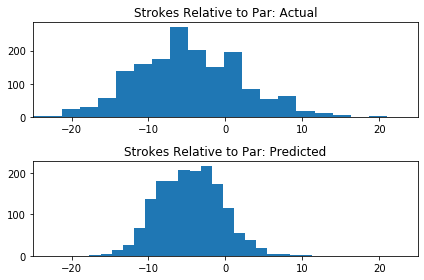

In [69]:
fig, ax = pl.subplots(2)

ax[0].hist(test_xgreg_target, bins = 20)
ax[0].set(xlim = (-25, 25))
ax[0].set_title('Strokes Relative to Par: Actual')
ax[1].hist(predictions, bins = 20)
ax[1].set(xlim = (-25, 25))
ax[1].set_title('Strokes Relative to Par: Predicted')

pl.tight_layout()
pl.show()

At this point, I'm feeling pretty great about the results!  With 80% recall of made cuts, a 70% rate of correctly predicting a made cut, and an average RMSE of 5 strokes, I feel comfortable continuing on with the rest of the work to build this model into a program which can make picks for me.  Below I have saved the models for future reference, and in later sections will begin researching the model's predictions on and for particular players and tournaments, and writing functions to feed inputs forward and generate predictions.

In [71]:
with open('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\xgbr_params.pkl', 'wb') as outfile:
    pickle.dump(xg_xgreg_params, outfile)

### Final Model Training

In [75]:
with open('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\svm_params.pkl', 'rb') as infile:
    svm_params = pickle.load(infile)
    
with open('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\xgbr_params.pkl', 'rb') as infile:
    xgbr_params = pickle.load(infile)

In [76]:
SVM = SVC(C = svm_params['C'], gamma = svm_params['gamma'], tol = svm_params['tol'])

In [77]:
SVM.fit(df_svm_features_SMOTE, df_svm_target_SMOTE)

SVC(C=10, gamma='auto')

In [78]:
XGR = XGBRegressor(subsample = xgbr_params['subsample'], n_estimators = xgbr_params['n_estimators'],
                   min_child_weight = xgbr_params['min_child_weight'], max_depth = xgbr_params['max_depth'],
                   learning_rate = xgbr_params['learning_rate'], gamma = xgbr_params['gamma'],
                   colsample_bytree = xgbr_params['colsample_bytree'])

In [79]:
XGR.fit(df_made_cut_features, df_made_cut_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
with open('Cut_Classifier.pkl', 'wb') as outfile:
    pickle.dump(SVM, outfile)
    
with open('Strokes_Regressor.pkl', 'wb') as outfile:
    pickle.dump(XGR, outfile)